In [102]:
import os
if len(os.getcwd().split('/')) != 8:
    os.chdir('..')
else:
    print(os.getcwd())

/Users/rohaan/Desktop/storage/RIT/federated_learning_lab/federated_learning


In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import json
import numpy as np
import random

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [104]:
def set_seed(seed):
    torch.manual_seed(seed)           # For CPU
    torch.cuda.manual_seed(seed)      # For CUDA (if using GPU)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    np.random.seed(seed)              # For NumPy
    random.seed(seed)                 # For Python's built-in random
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Turn off optimization for reproducibility

In [105]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 as required by LeNet-5
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
print(f"Datasets:\n\t-> TRAIN: {'available' if train_dataset else 'N/A'}\n\t-> TEST: {'available' if train_dataset else 'N/A'}")

Datasets:
	-> TRAIN: available
	-> TEST: available


In [106]:
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

print(f"Datasets:\n\t-> TRAIN: {len(train_loader.dataset)} samples\n\t-> TEST: {len(test_loader.dataset)} samples")

Datasets:
	-> TRAIN: 60000 samples
	-> TEST: 10000 samples


In [107]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # kernel_size aka filter size
        # out_channels aka number of filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = torch.tanh(x) 
        # layer 2
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 3
        x = self.conv2(x)
        x = torch.tanh(x) 
        # layer 4
        x = nn.functional.avg_pool2d(input=x, kernel_size=2, stride=2)
        x = torch.tanh(x) 
        # layer 5
        x = self.conv3(x)
        x = torch.tanh(x) 
        # layer 6
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.tanh(x) 
        # output layer
        x = self.fc2(x)
        # x = nn.functional.softmax(x, dim=1)  # remove softmax if using crossEntropy since it applies the softmax function too
    
        return x

In [108]:
def get_batch_by_idx(train_loader, batch_idx):
    # Calculate start and end indices for the batch
    start_idx = batch_idx * train_loader.batch_size
    end_idx = start_idx + train_loader.batch_size
    
    if end_idx > len(train_loader.dataset):
        end_idx = len(train_loader.dataset)

    # Fetch the data and target tensors for that batch
    data_list, target_list = [], []
    for idx in range(start_idx, end_idx):
        data, target = train_loader.dataset[idx]
        data_list.append(data)
        target_list.append(target)

    # Stack the list into a batch
    data_batch = torch.stack(data_list)
    target_batch = torch.tensor(target_list)

    return data_batch, target_batch

In [109]:
def train(model, device, train_loader, optimizer, criterion, batch_idx, track_weights=False):
    model.train()
    train_loss = 0
    
    # current weights
    w_t = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    
    data, target = get_batch_by_idx(train_loader, batch_idx)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    
    # new weights
    w_t_plus_1 = {name: weights.clone().detach().cpu() for name, weights in model.state_dict().items()}
    updates = {
        name: (w_t[name] - w_t_plus_1[name]).tolist() 
        for name in w_t_plus_1}
    
    return updates, loss

In [110]:
def initialize_model(seed=42):
    # Set the seed for reproducible results
    set_seed(seed)
    model = LeNet5()
    return model

In [111]:
model = initialize_model(seed=1829).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [112]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return avg_test_loss, accuracy

In [113]:
rounds = len(train_loader)
print(f"Rounds: {rounds}, Batch Size: {train_loader.batch_size}")

Rounds: 235, Batch Size: 256


In [114]:
train_losses = []
test_losses = []
accuracies = []

for round in range(1, 1 + rounds):
    print(f"Running round {round}/{rounds}")
    updates, loss = train(model=model, 
                          device=device, 
                          train_loader=train_loader, 
                          optimizer=optimizer, 
                          criterion=criterion, 
                          batch_idx=round-1)
    
    avg_test_loss, accuracy = test(model, device, test_loader)
    
    train_losses.append(float(loss))
    test_losses.append(avg_test_loss)
    accuracies.append(accuracy)

Running round 1/235

Test set: Average loss: 0.0020, Accuracy: 4698/10000 (47%)

Running round 2/235

Test set: Average loss: 0.0015, Accuracy: 5616/10000 (56%)

Running round 3/235

Test set: Average loss: 0.0012, Accuracy: 6540/10000 (65%)

Running round 4/235

Test set: Average loss: 0.0010, Accuracy: 6873/10000 (69%)

Running round 5/235

Test set: Average loss: 0.0008, Accuracy: 7252/10000 (73%)

Running round 6/235

Test set: Average loss: 0.0007, Accuracy: 8055/10000 (81%)

Running round 7/235

Test set: Average loss: 0.0006, Accuracy: 8181/10000 (82%)

Running round 8/235

Test set: Average loss: 0.0006, Accuracy: 8085/10000 (81%)

Running round 9/235

Test set: Average loss: 0.0005, Accuracy: 8444/10000 (84%)

Running round 10/235

Test set: Average loss: 0.0005, Accuracy: 8235/10000 (82%)

Running round 11/235

Test set: Average loss: 0.0005, Accuracy: 8231/10000 (82%)

Running round 12/235

Test set: Average loss: 0.0005, Accuracy: 8343/10000 (83%)

Running round 13/235

Tes

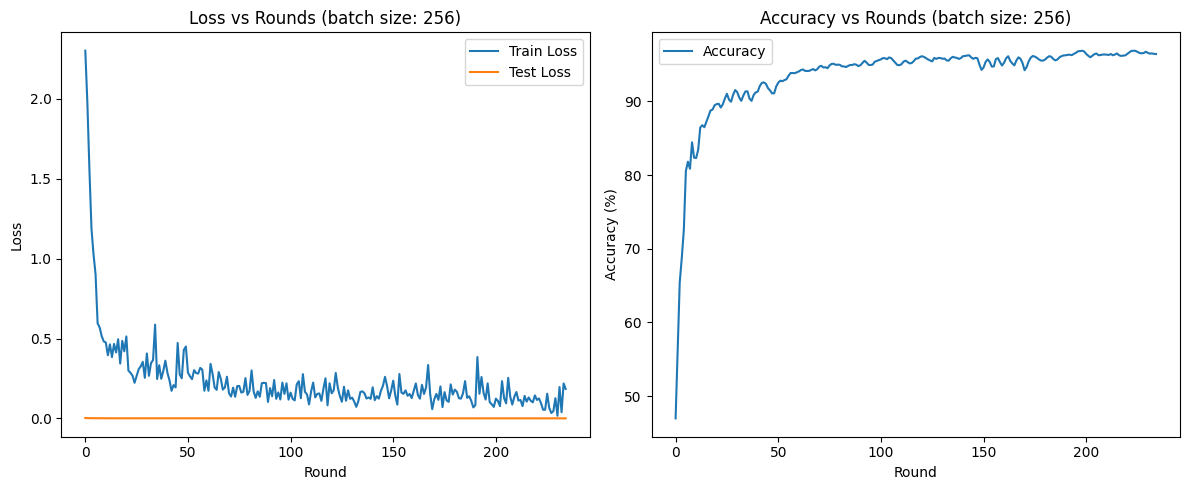

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss vs Rounds (batch size: 256)')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Rounds (batch size: 256)')
plt.legend()

plt.tight_layout()
plt.show()